# UnDRground Tubes Computational Experiment Results

UT writes several files during its execution to capture the embedding, the network, and information about the ILPs. These files are located in the folder `designspace-results/results`. First a few utility functions, loading necessary modules, and then reading all those files into a `Pandas` dataframe.

In [264]:
import os
import json
import copy
import pandas as pd
import math
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, HTML
from shutil import get_terminal_size


mpl.rc("text", usetex=True)
mpl.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}\usepackage{calrsfs}\DeclareMathAlphabet{\pazocal}{OMS}{zplm}{m}{n}\SetMathAlphabet\pazocal{bold}{OMS}{zplm}{bx}{n}\newcommand{\mth}{\mathcal{A}}\newcommand{\pzc}{\pazocal{A}}')


FAKE = {
    "mip": False,
    "has_mipgap": None,
    "mipgap": None,
    "runtime_ms": None,
    "status": None,
}


In [265]:
def flatten_dict(d, prefix):
    is_dict = isinstance(d, dict)

    newdict = dict()
    if is_dict:
        for k, v in d.items():
            nk = f"{prefix}.{k}"
            newdict[nk] = copy.deepcopy(v)
    return newdict


def flatten_list(d, prefix):
    is_list = isinstance(d, list)

    newdict = dict()
    if is_list:
        r = []
        for i, v in enumerate(d):
            nk = f"{prefix}[{i}]"
            r.append(flatten_dict(v, nk))
        for dic in r:
            newdict = newdict | dic

    return newdict


In [266]:
FOLDER = "./results"
PREFIX = "esvis-ds"

folders_with_call_file = []

for subdir, dirs, files in os.walk(FOLDER):
    if "call.json" in files and subdir.startswith(os.path.join(FOLDER, PREFIX)):
        folders_with_call_file.append(subdir)

calls = []
for dir in folders_with_call_file:
    callfile = os.path.join(dir, "call.json")
    with open(callfile, "r") as f:
        call = json.load(f)
        call = call | flatten_dict(call["ctx"], "ctx")
        del call["ctx"]
        if "metrics" in call:
            call = call | flatten_list(call["metrics"], "metrics")
            del call["metrics"]

        # also merge the embedding metrics
        embedding_metrics = None
        try:
            with open(os.path.join(dir, 'metrics_embedding.json')) as f:
                embedding_metrics = json.load(f)
                call = call | embedding_metrics[0]
        except:
            pass

        # merge also the additional files
        for ilp_status_file in ["connect", "overlapremoval", "route", 'layout']:
            filename = f"ilp_status_{ilp_status_file}_0.json"
            filepath = os.path.join(dir, filename)
            status_file_exists = os.path.exists(filepath)
            if status_file_exists:
                with open(filepath, "r") as f:
                    status_file_data = flatten_dict(
                        json.load(f), f"ilp_{ilp_status_file}"
                    )
                    call = call | status_file_data
            else:
                call = call | FAKE
        calls.append(call)

df = pd.DataFrame(data=calls)


In [274]:
# post process
df["success"] = df.success.astype("bool")
df['dataset'] = df['ctx.general.dataset'].astype(str).map(lambda s:s[ s.index('_') + 1 : s.index('_') + 1 + s[s.index('_') + 1:].index('_')])
df['duration_s'] = df['duration_ms'].astype(float).map(lambda d: d / 1000)
df['duration_m'] = df['duration_ms'].astype(float).map(lambda d: d / 60_000)

df[['M1 [EA, k=10%]', 'M2 [EA, k=10%]']] = df['EA: (M1, M2) [k=10%]'].apply(pd.Series)
df[['M1 [SR, k=10%]', 'M2 [SR, k=10%]']] = df['SR: (M1, M2) [k=10%]'].apply(pd.Series)
df['M1 [EA, k=10%] avg'] = (df['M1 [EA, k=10%]'] + df['M1 [SR, k=10%]']) / 2
df['M2 [EA, k=10%] avg'] = (df['M2 [EA, k=10%]'] + df['M2 [SR, k=10%]']) / 2
df['stress avg'] = (df['EA: stress'] + df['SR: stress']) / 2

dataset_order = list(map(lambda i: f"dataset{i}", range(10)))

df['is_opt'] = df[['ctx.connect.connecter', 'ctx.route.router']].aggregate(lambda x: all(x=='opt'), axis=1)



From here the actual results are investigated.

## Runtime

This heatmap contains the runtime of all successful runs in minutes. On the Y axis we have groups of `{overlapremover: dgrid/hagrid}`, `{support: opt/heuristic}-{routing: opt/heuristic}-{support_type: path/tree}`. On the X axis are groups of `{weight}-{dataset}`.

It is visible that the heuristic runtimes are below 5 minutes, except for Hagrid and weight = 1. Optimal supports seem feasible for `N` up to `100`, i.e., `dataset5`, at least with heuristic routing and tree supports.

A few cells in between are missing which indicates failed runs. They happen mostly for path supports and could be related to software errors.

<Axes: xlabel='ctx.general.weight-dataset', ylabel='ctx.layout.overlapremover-ctx.connect.connecter-ctx.route.router-ctx.general.subsupporttype'>

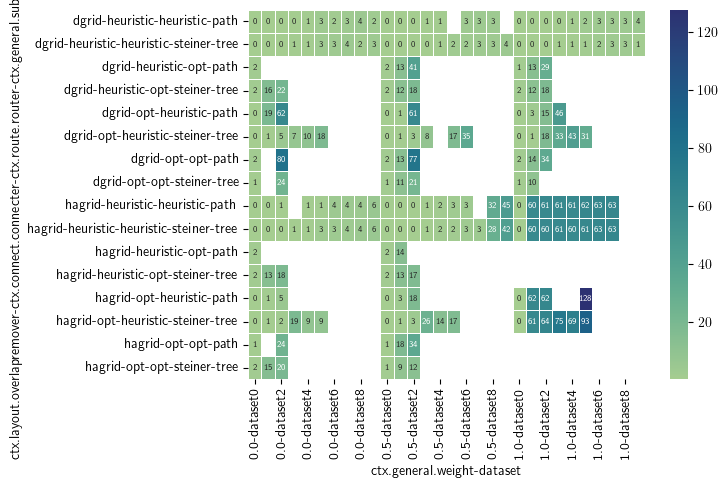

In [268]:
import matplotlib.pyplot as plt

weight = 0.5
good_runs = df[(df["success"] == True)]
sns.heatmap(
    good_runs.pivot_table(
        index=[
            "ctx.layout.overlapremover",
            "ctx.connect.connecter",
            "ctx.route.router",
            "ctx.general.subsupporttype",
        ],
        columns=[
            "ctx.general.weight",
            "dataset", 
        ],
        values="duration_m",
        aggfunc='min',
    ),
    linewidth=0.5,
    annot=True,
    annot_kws={"fontsize":6},
    fmt=".0f",
    cmap="crest",
)


## Projections

Let's plot the quality metrics for the projection. We are interested in how they relate to the weight parameter.

All metrics (trustworthiness, continuity, stress) show the same pattern. (Higher is better for the former two, lower is better for the latter.) For element similarity, the projection is best for weight 0, worse for 0.5 and worst at 1. For set similairty, it is the other way around. Considering an average of both metrics, weight 0.5 is the best.

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2222711357.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2222711357.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2222711357.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2222711357.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(["$%.1f$" % i for i in axes[0].get_yticks()], fontsize = 20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2222711357.py:31: UserWarning: FixedFormatter should only be used together with 

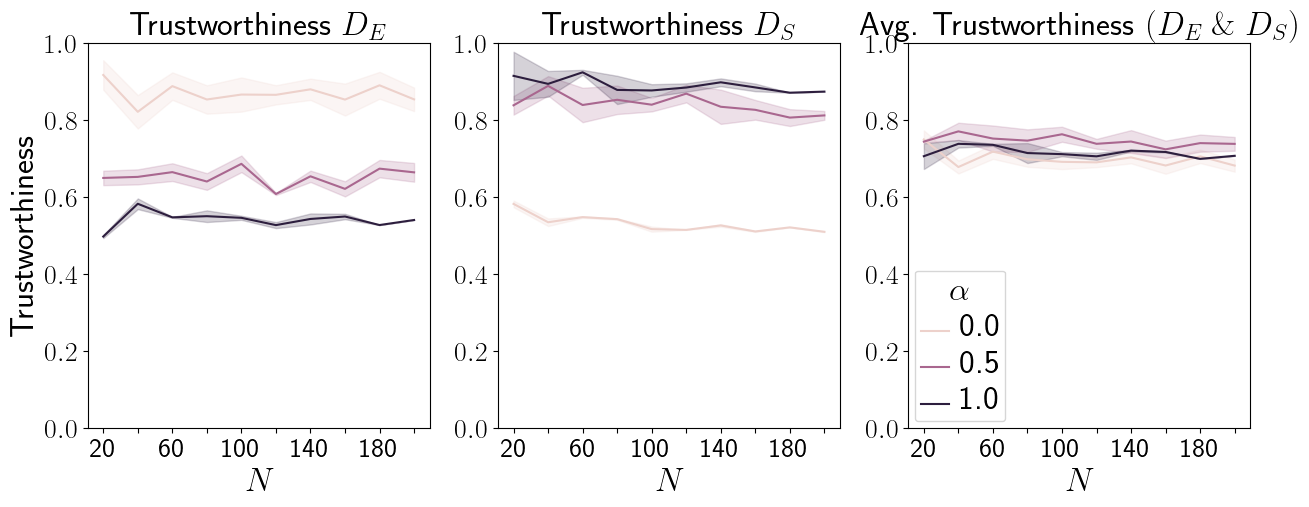

In [275]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

axes[0].set_title('Trustworthiness $D_E$', fontsize=24)
axes[1].set_title('Trustworthiness $D_S$', fontsize=24)
axes[2].set_title('Avg. Trustworthiness $(D_E \; \& \; D_S)$', fontsize=24)

all_runs = df.sort_values('dataset')

sns.lineplot(data=all_runs, x="dataset", y="M1 [EA, k=10%]", hue="ctx.general.weight", sort=False, errorbar='sd', ax=axes[0], legend=None)
sns.lineplot(data=all_runs, x="dataset", y="M1 [SR, k=10%]", hue="ctx.general.weight", sort=False, errorbar='sd', ax=axes[1], legend=None)
sns.lineplot(data=all_runs, x="dataset", y="M1 [EA, k=10%] avg", hue="ctx.general.weight", sort=False, errorbar='sd', ax=axes[2])

labels = list(range(20,201, 20))
axes[0].set_ylim([0, 1])
axes[1].set_ylim([0, 1])
axes[2].set_ylim([0, 1])

axes[2].get_legend().set_title("$\\alpha$")
plt.setp(axes[2].get_legend().get_texts(), fontsize='24') # for legend text
plt.setp(axes[2].get_legend().get_title(), fontsize='24') # for legend title

for i in range(len(labels)):
    if i % 2 == 1:
        labels[i] = ""

axes[0].set_xticklabels(labels, fontsize=20)
axes[1].set_xticklabels(labels, fontsize=20)
axes[2].set_xticklabels(labels, fontsize=20)

axes[0].set_yticklabels(["$%.1f$" % i for i in axes[0].get_yticks()], fontsize = 20)
axes[1].set_yticklabels(["$%.1f$" % i for i in axes[1].get_yticks()], fontsize = 20)
axes[2].set_yticklabels(["$%.1f$" % i for i in axes[2].get_yticks()], fontsize = 20)

axes[0].set_xlabel("$N$", fontsize=24)
axes[1].set_xlabel("$N$", fontsize=24)
axes[2].set_xlabel("$N$", fontsize=24)
axes[0].set_ylabel("Trustworthiness", fontsize=24)
axes[1].set_ylabel("")
axes[2].set_ylabel("")

fig.savefig(f"trustworthiness.pdf", bbox_inches = "tight") 

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/772172928.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/772172928.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/772172928.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels)


Text(0, 0.5, '$M_2 (EA + SR)$')

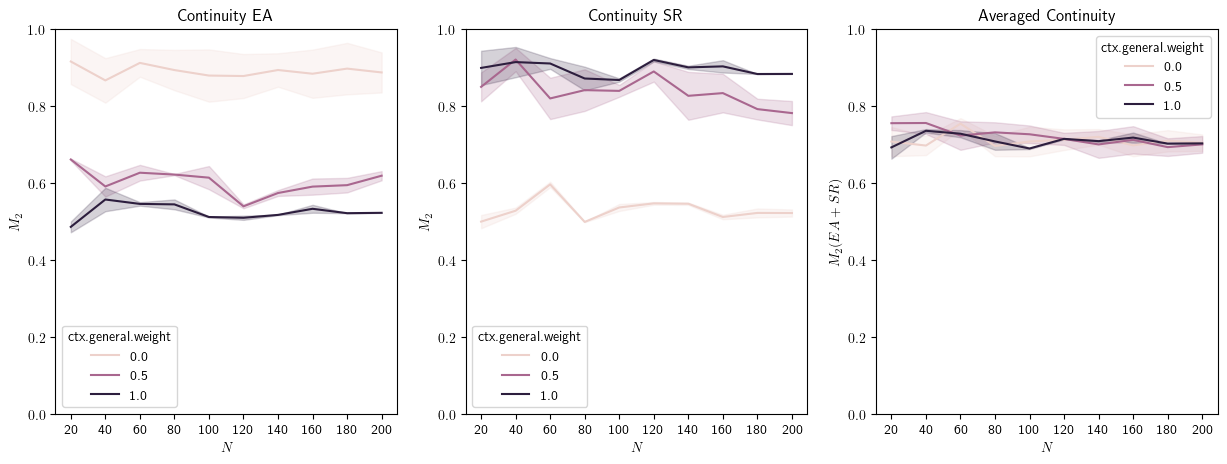

In [276]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

axes[0].set_title('Continuity EA')
axes[1].set_title('Continuity SR')
axes[2].set_title('Averaged Continuity')

all_runs = df.sort_values('dataset')

sns.lineplot(data=all_runs, x="dataset", y="M2 [EA, k=5]", hue="ctx.general.weight", sort=False, errorbar='sd', ax=axes[0])
sns.lineplot(data=all_runs, x="dataset", y="M2 [SR, k=5]", hue="ctx.general.weight", sort=False, errorbar='sd', ax=axes[1])
sns.lineplot(data=all_runs, x="dataset", y="M2 [EA, k=5] avg", hue="ctx.general.weight", sort=False, errorbar='sd', ax=axes[2])

labels = range(20,201, 20)
axes[0].set_ylim([0, 1])
axes[1].set_ylim([0, 1])
axes[2].set_ylim([0, 1])


axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels)
axes[2].set_xticklabels(labels)
axes[0].set_xlabel("$N$")
axes[1].set_xlabel("$N$")
axes[2].set_xlabel("$N$")
axes[0].set_ylabel("$M_2$")
axes[1].set_ylabel("$M_2$")
axes[2].set_ylabel("$M_2 (EA + SR)$")

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3141558168.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3141558168.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3141558168.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3141558168.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(["$%.2f$" % i for i in axes[0].get_yticks()], fontsize = 20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3141558168.py:31: UserWarning: FixedFormatter should only be used together with 

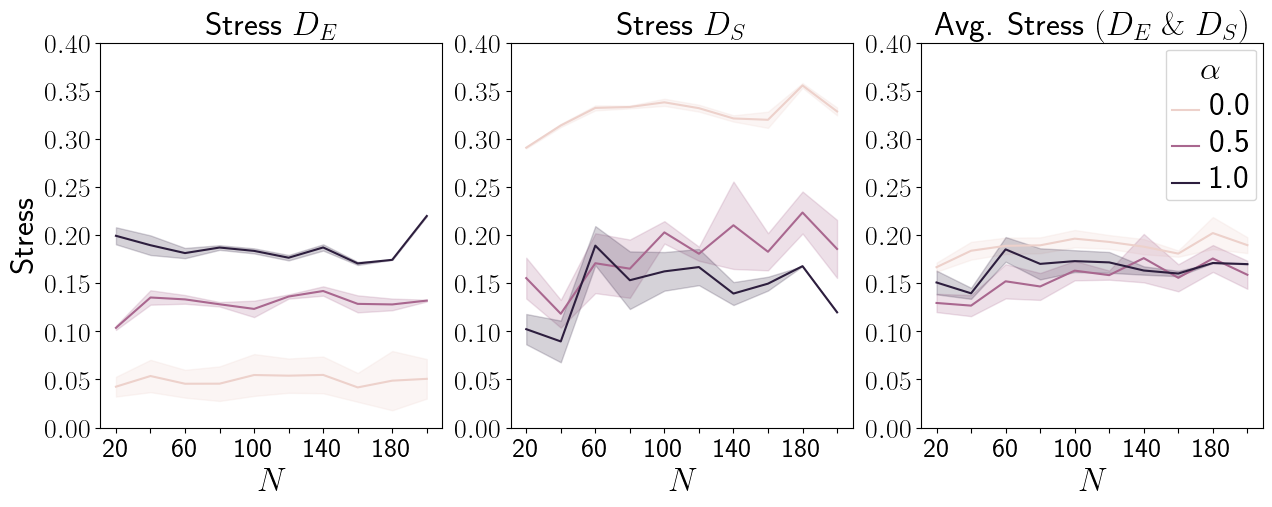

In [277]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

axes[0].set_title('Stress $D_E$', fontsize=24)
axes[1].set_title('Stress $D_S$', fontsize=24)
axes[2].set_title('Avg. Stress $(D_E \; \& \; D_S)$', fontsize=24)

all_runs = df.sort_values('dataset')

sns.lineplot(data=all_runs, x="dataset", y="EA: stress", hue="ctx.general.weight", sort=False, errorbar='sd', ax=axes[0], legend=None)
sns.lineplot(data=all_runs, x="dataset", y="SR: stress", hue="ctx.general.weight", sort=False, errorbar='sd', ax=axes[1], legend=None)
sns.lineplot(data=all_runs, x="dataset", y="stress avg", hue="ctx.general.weight", sort=False, errorbar='sd', ax=axes[2])

labels = list(range(20,201, 20))
axes[0].set_ylim([0, 0.4])
axes[1].set_ylim([0, 0.4])
axes[2].set_ylim([0, 0.4])

axes[2].get_legend().set_title("$\\alpha$")
plt.setp(axes[2].get_legend().get_texts(), fontsize='24') # for legend text
plt.setp(axes[2].get_legend().get_title(), fontsize='24') # for legend title

for i in range(len(labels)):
    if i % 2 == 1:
        labels[i] = ""

axes[0].set_xticklabels(labels, fontsize=20)
axes[1].set_xticklabels(labels, fontsize=20)
axes[2].set_xticklabels(labels, fontsize=20)

axes[0].set_yticklabels(["$%.2f$" % i for i in axes[0].get_yticks()], fontsize = 20)
axes[1].set_yticklabels(["$%.2f$" % i for i in axes[1].get_yticks()], fontsize = 20)
axes[2].set_yticklabels(["$%.2f$" % i for i in axes[2].get_yticks()], fontsize = 20)

axes[0].set_xlabel("$N$", fontsize=24)
axes[1].set_xlabel("$N$", fontsize=24)
axes[2].set_xlabel("$N$", fontsize=24)
axes[0].set_ylabel("Stress", fontsize=24)
axes[1].set_ylabel("")
axes[2].set_ylabel("")

fig.savefig(f"Stress.pdf", bbox_inches = "tight") 

## Network structure

Next, we consider the number of (straight-line, i.e., between grid nodes) edges in the drawing, the number of lines routed on them, and the number of line crossings (both at grid nodes and at diagonal edges). As the increasing weight forms more nicely clustered structures, fewer edges are necessary and, since the nodes are arranged by labels, fewer lines cross.

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3739239576.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3739239576.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3739239576.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels)


Text(0, 0.5, '\\# Line Crossings')

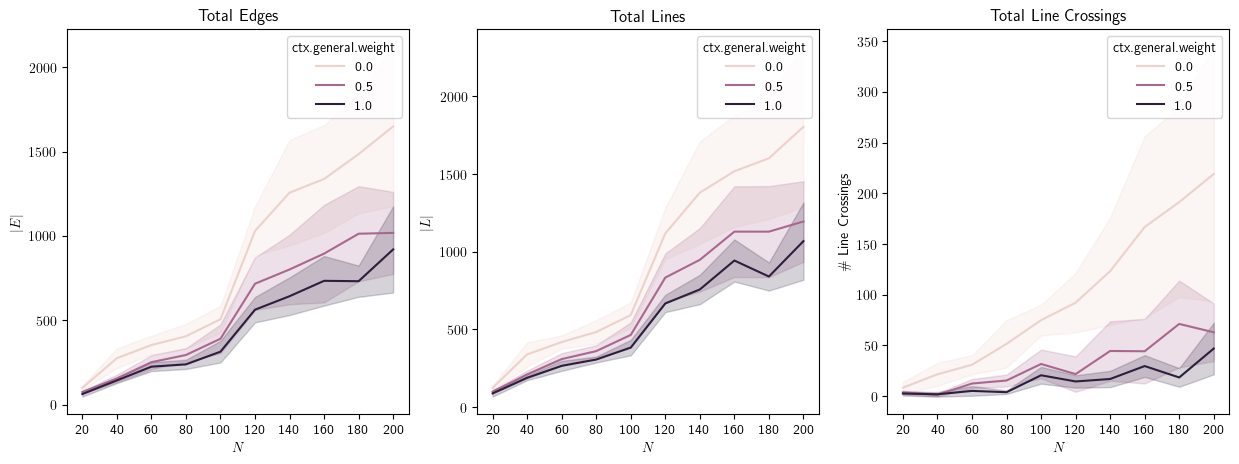

In [278]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

good_runs = df[(df["success"] == True)].sort_values('dataset')

axes[0].set_title('Total Edges')
axes[1].set_title('Total Lines')
axes[2].set_title('Total Line Crossings')

sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_edges", hue="ctx.general.weight", errorbar='sd',sort=False, ax=axes[0])
sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_lines", hue="ctx.general.weight", errorbar='sd',sort=False, ax=axes[1])
sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_line_crossings", hue="ctx.general.weight", errorbar='sd',sort=False, ax=axes[2])

labels = range(20,201, 20)

axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels)
axes[2].set_xticklabels(labels)
axes[0].set_xlabel("$N$")
axes[1].set_xlabel("$N$")
axes[2].set_xlabel("$N$")
axes[0].set_ylabel("$|E|$")
axes[1].set_ylabel("$|L|$")
axes[2].set_ylabel("\# Line Crossings")

Does it pay off to use UT's optimal support setting? The next plot shows the network quality metrics grouped by that setting (orange = opt). They show that, as expected, fewer edges are used in the drawing with the optimal support. 

For lines and line crossings, however, we do not see this effect. For total lines it is intuitively logical. Consider two lines on two separate edges that are merged onto one edge. Then the two lines run parallel on that one edge, i.e., the line count is unchanged. A joint support can lead to longer lines than they would be in a separate support.

We would expect that an optimal support leads to fewer line crossings, but this does not seem to be the case, generally. It might be caused by discrepancies between the support and routing steps, as the former does not consider obstacles that the latter has to deal with.

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/4240202069.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/4240202069.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/4240202069.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/4240202069.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(["%.0f" % i for i in axes[0].get_yticks()], fontsize = 20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/4240202069.py:35: UserWarning: FixedFormatter should only be used together with Fi

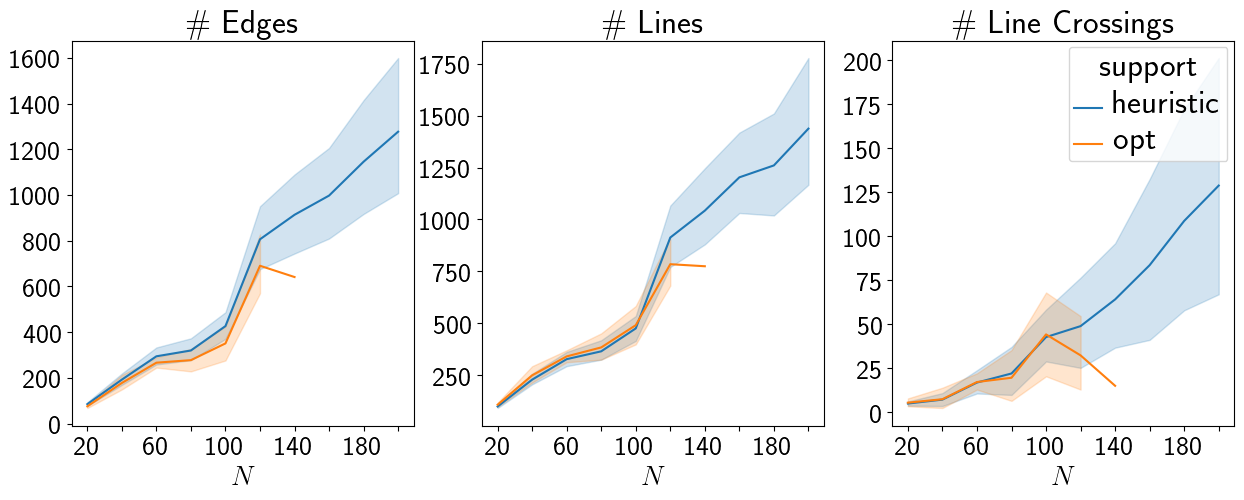

In [309]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

good_runs = df[(df["success"] == True)].sort_values('dataset')

axes[0].set_title('Total Edges')
axes[1].set_title('Total Lines')
axes[2].set_title('Total Line Crossings')

sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_edges", hue="ctx.connect.connecter", ax=axes[0], legend=None)
sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_lines", hue="ctx.connect.connecter", ax=axes[1], legend=None)
sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_line_crossings", hue="ctx.connect.connecter", ax=axes[2])

labels = list(range(20,201, 20))

axes[0].set_title('\# Edges', fontsize=24)
axes[1].set_title('\# Lines', fontsize=24)
axes[2].set_title('\# Line Crossings', fontsize=24)

axes[2].get_legend().set_title("support")
plt.setp(axes[2].get_legend().get_texts(), fontsize='24') # for legend text
plt.setp(axes[2].get_legend().get_title(), fontsize='24') # for legend title

for i in range(len(labels)):
    if i % 2 == 1:
        labels[i] = ""

axes[0].set_xticklabels(labels, fontsize=20)
axes[1].set_xticklabels(labels, fontsize=20)
axes[2].set_xticklabels(labels, fontsize=20)
axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")

axes[0].set_yticklabels(["%.0f" % i for i in axes[0].get_yticks()], fontsize = 20)
axes[1].set_yticklabels(["%.0f" % i for i in axes[1].get_yticks()], fontsize = 20)
axes[2].set_yticklabels(["%.0f" % i for i in axes[2].get_yticks()], fontsize = 20)

axes[0].set_xticklabels(labels, fontsize=20)
axes[1].set_xticklabels(labels, fontsize=20)
axes[2].set_xticklabels(labels, fontsize=20)
axes[0].set_xlabel("$N$", fontsize=20)
axes[1].set_xlabel("$N$", fontsize=20)
axes[2].set_xlabel("$N$", fontsize=20)

fig.savefig(f"network.pdf", bbox_inches = "tight") 

And as expected we see that the metrics are worse for a path than a tree support. The jump in all metrics from `N=100` to `120` is most likely related to the larger grid (64x64) that is used from that instance on.

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2958382473.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2958382473.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2958382473.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2958382473.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(["%.0f" % i for i in axes[0].get_yticks()], fontsize = 20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2958382473.py:35: UserWarning: FixedFormatter should only be used together with Fi

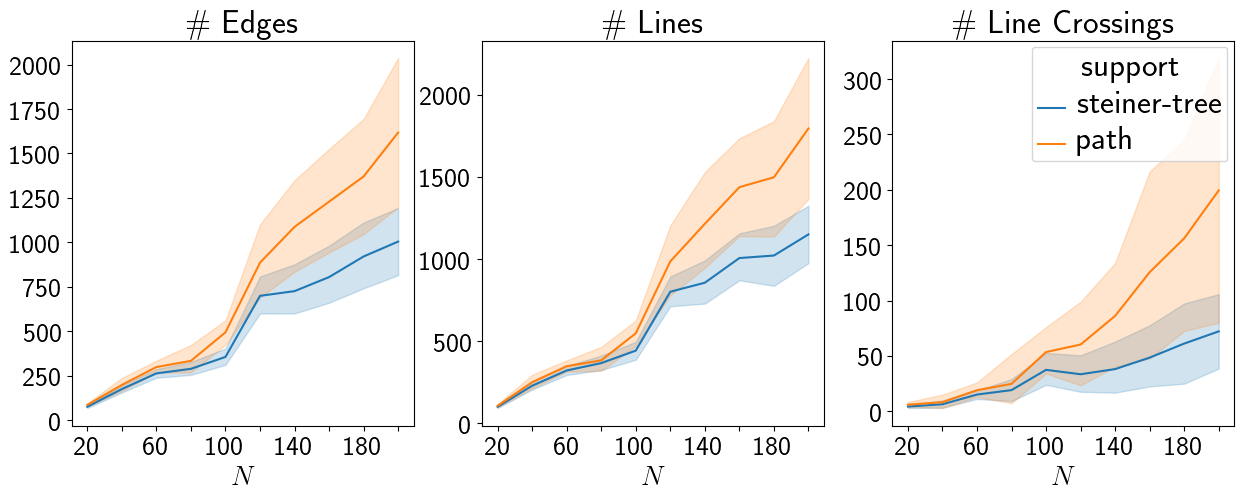

In [308]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

good_runs = df[(df["success"] == True)].sort_values('dataset')

axes[0].set_title('Total Edges')
axes[1].set_title('Total Lines')
axes[2].set_title('Total Line Crossings')

sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_edges", hue="ctx.general.subsupporttype", ax=axes[0], legend=None)
sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_lines", hue="ctx.general.subsupporttype", ax=axes[1], legend=None)
sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_line_crossings", hue="ctx.general.subsupporttype", ax=axes[2])

labels = list(range(20,201, 20))

axes[0].set_title('\# Edges', fontsize=24)
axes[1].set_title('\# Lines', fontsize=24)
axes[2].set_title('\# Line Crossings', fontsize=24)

axes[2].get_legend().set_title("support")
plt.setp(axes[2].get_legend().get_texts(), fontsize='24') # for legend text
plt.setp(axes[2].get_legend().get_title(), fontsize='24') # for legend title

for i in range(len(labels)):
    if i % 2 == 1:
        labels[i] = ""

axes[0].set_xticklabels(labels, fontsize=20)
axes[1].set_xticklabels(labels, fontsize=20)
axes[2].set_xticklabels(labels, fontsize=20)
axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")

axes[0].set_yticklabels(["%.0f" % i for i in axes[0].get_yticks()], fontsize = 20)
axes[1].set_yticklabels(["%.0f" % i for i in axes[1].get_yticks()], fontsize = 20)
axes[2].set_yticklabels(["%.0f" % i for i in axes[2].get_yticks()], fontsize = 20)

axes[0].set_xticklabels(labels, fontsize=20)
axes[1].set_xticklabels(labels, fontsize=20)
axes[2].set_xticklabels(labels, fontsize=20)
axes[0].set_xlabel("$N$", fontsize=20)
axes[1].set_xlabel("$N$", fontsize=20)
axes[2].set_xlabel("$N$", fontsize=20)

fig.savefig(f"network.pdf", bbox_inches = "tight") 

## ILPs

How did the ILPs do in the pipeline? Let's first check their status. Status `2` means solved to optimality, status `3` means infeasible, and status `9` means the solver ran into the specified timeout.

The histograms count the number of times that happened. The top left panel shows cases where both found the optimal solution. The top right panel shows two cases where the support ILP ran into the timeout. In the bottom left we see where the routing ILP was infeasible - this happened 8 times for Hagrid at weight 1 and 1 time for DGrid at weight 1.

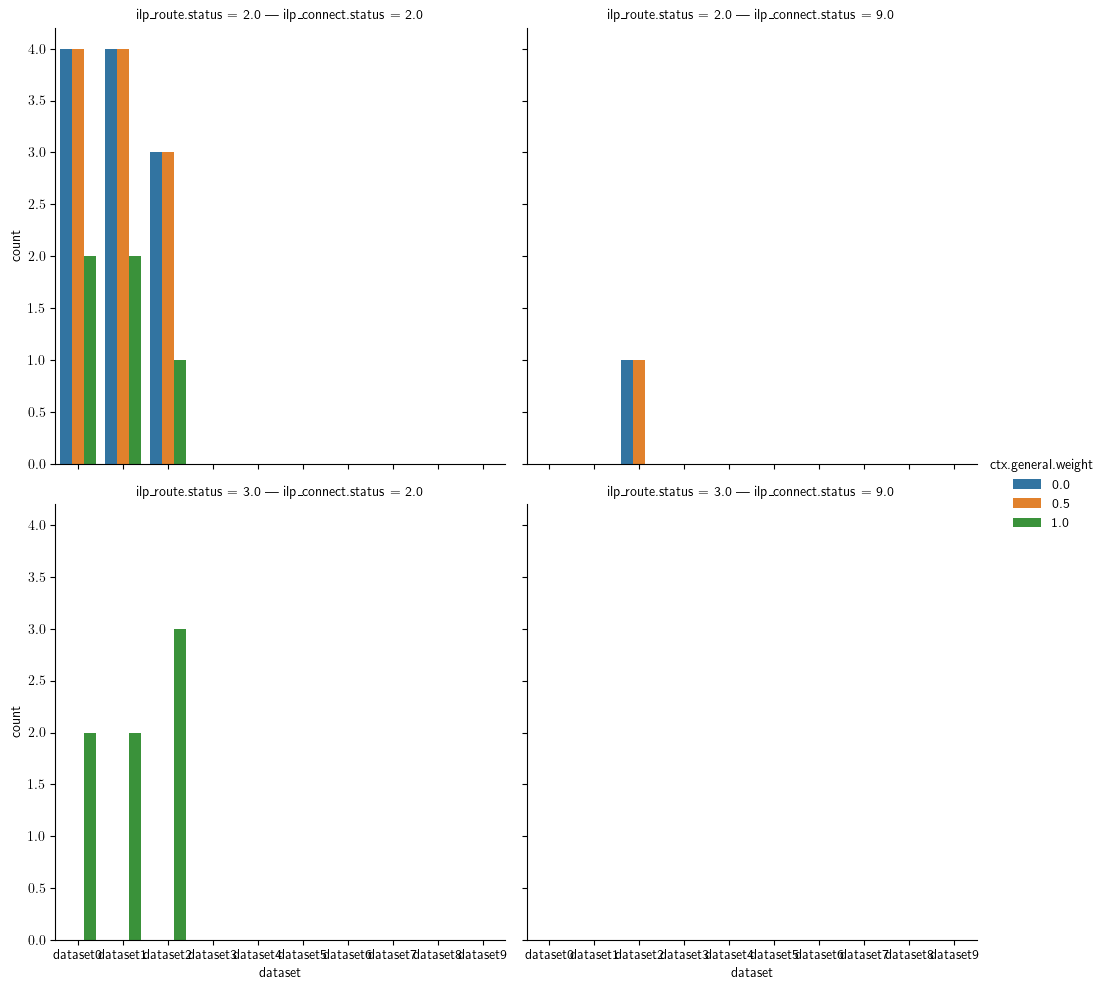

In [289]:
good_runs = df[(df["success"] == True)]


sns.catplot(data=df[df['is_opt']==True], kind='count', x="dataset", row='ilp_route.status', col='ilp_connect.status', hue='ctx.general.weight',dodge=True, order=dataset_order)


Let's check the MIP gaps for the ILPs of successful runs.

### Support ILP

<Axes: xlabel='dataset', ylabel='ilp_connect.mipgap'>

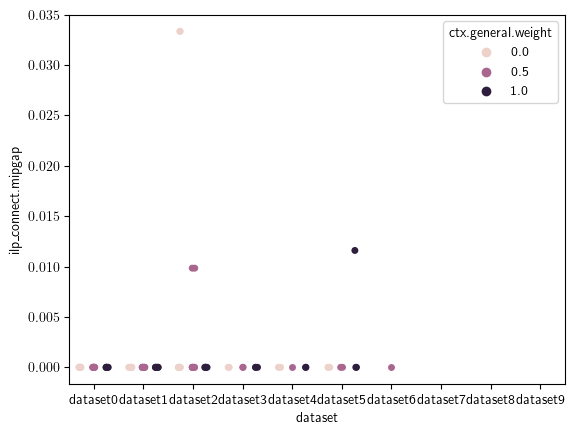

In [291]:
good_runs = df[(df["success"] == True)]


sns.stripplot(data=good_runs, x="dataset", y='ilp_connect.mipgap', hue='ctx.general.weight',dodge=True, order=dataset_order)


### Routing ILP

<Axes: xlabel='dataset', ylabel='ilp_route.mipgap'>

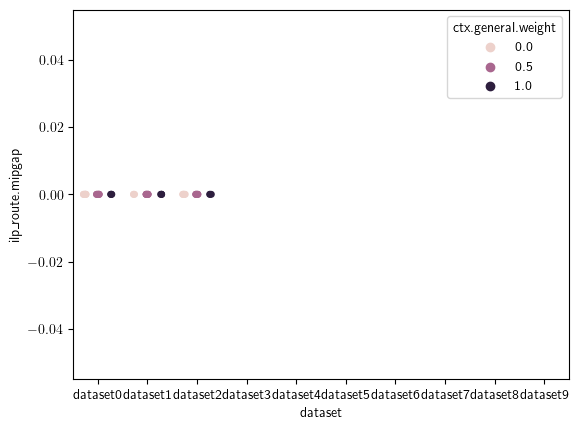

In [293]:
good_runs = df[(df["success"] == True)]


sns.stripplot(data=good_runs, x="dataset", y='ilp_route.mipgap', hue='ctx.general.weight',dodge=True, order=dataset_order)


### Hagrid ILP

<Axes: xlabel='dataset', ylabel='ilp_overlapremoval.mipgap'>

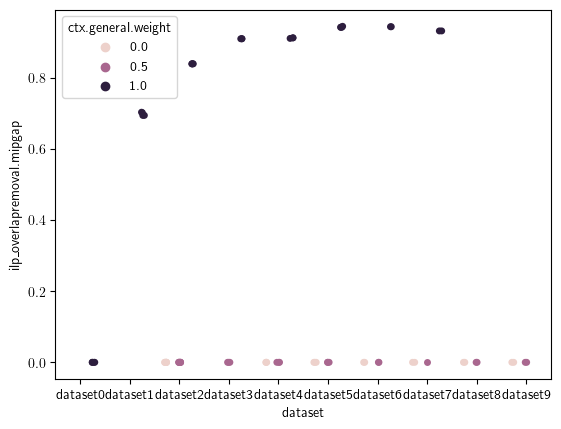

In [294]:
good_runs = df[(df["success"] == True)]


sns.stripplot(data=good_runs, x="dataset", y='ilp_overlapremoval.mipgap', hue='ctx.general.weight',dodge=True, order=dataset_order)


# Overlap Removal

The overlap removal step influences the grid layout greatly, so let's check if there are differences between DGrid and Hagrid when it comes to the previously used metrics.

DGrid seems to lead to slightly better network metrics on average, but their SD bands overlap a lot, so it still depends on the exact instance of parameter settings. Note also (see previous plot) that our Hagrid ILP doesn't fare well on instances larger than 20 elements at weight 1, so the difference in metrics is likely also related to that issue.

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3788925128.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3788925128.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3788925128.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels, fontsize=20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3788925128.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(["%.0f" % i for i in axes[0].get_yticks()], fontsize = 20)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/3788925128.py:35: UserWarning: FixedFormatter should only be used together with Fi

Text(0.5, 0, '$N$')

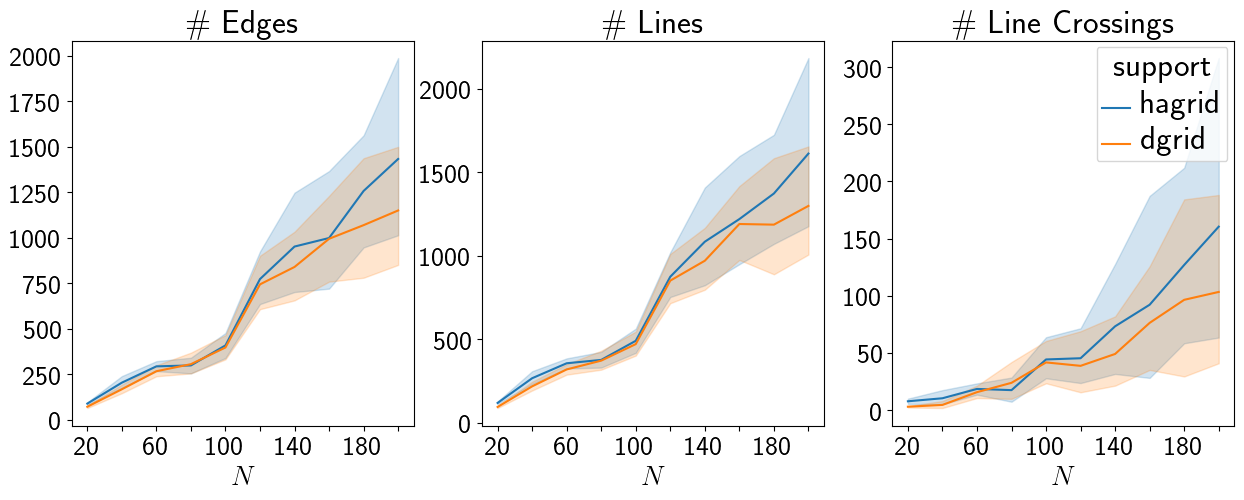

In [316]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

good_runs = df[(df["success"] == True)].sort_values('dataset')

axes[0].set_title('Total Edges')
axes[1].set_title('Total Lines')
axes[2].set_title('Total Line Crossings')

sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_edges", hue="ctx.layout.overlapremover", ax=axes[0], legend=None)
sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_lines", hue="ctx.layout.overlapremover", ax=axes[1], legend=None)
sns.lineplot(data=good_runs, x="dataset", y="metrics[0].total_line_crossings", hue="ctx.layout.overlapremover", ax=axes[2])

labels = list(range(20,201, 20))

axes[0].set_title('\# Edges', fontsize=24)
axes[1].set_title('\# Lines', fontsize=24)
axes[2].set_title('\# Line Crossings', fontsize=24)

axes[2].get_legend().set_title("gridifier")
plt.setp(axes[2].get_legend().get_texts(), fontsize='24') # for legend text
plt.setp(axes[2].get_legend().get_title(), fontsize='24') # for legend title

for i in range(len(labels)):
    if i % 2 == 1:
        labels[i] = ""

axes[0].set_xticklabels(labels, fontsize=20)
axes[1].set_xticklabels(labels, fontsize=20)
axes[2].set_xticklabels(labels, fontsize=20)
axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")

axes[0].set_yticklabels(["%.0f" % i for i in axes[0].get_yticks()], fontsize = 20)
axes[1].set_yticklabels(["%.0f" % i for i in axes[1].get_yticks()], fontsize = 20)
axes[2].set_yticklabels(["%.0f" % i for i in axes[2].get_yticks()], fontsize = 20)

axes[0].set_xticklabels(labels, fontsize=20)
axes[1].set_xticklabels(labels, fontsize=20)
axes[2].set_xticklabels(labels, fontsize=20)
axes[0].set_xlabel("$N$", fontsize=20)
axes[1].set_xlabel("$N$", fontsize=20)
axes[2].set_xlabel("$N$", fontsize=20)


What about the projection metrics? Lets plot everything grouped by gridifier and weight.

## Trustworthiness

1st row is trustworthiness for elements (EA), 2n row is trustworthiness for set relations (SR), 3rd row the average of both.

It can be seen that DGrid produces almost always a better projection according to trustworthiness (higher is better).

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/1840217087.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(range(20,201,20)))


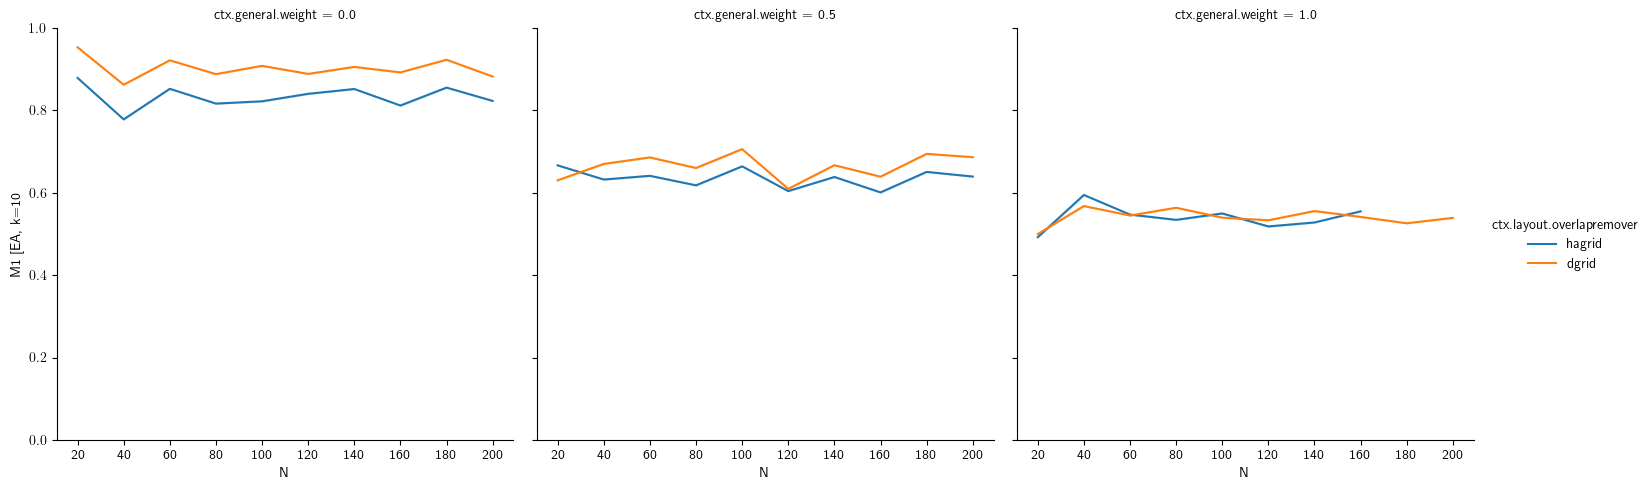

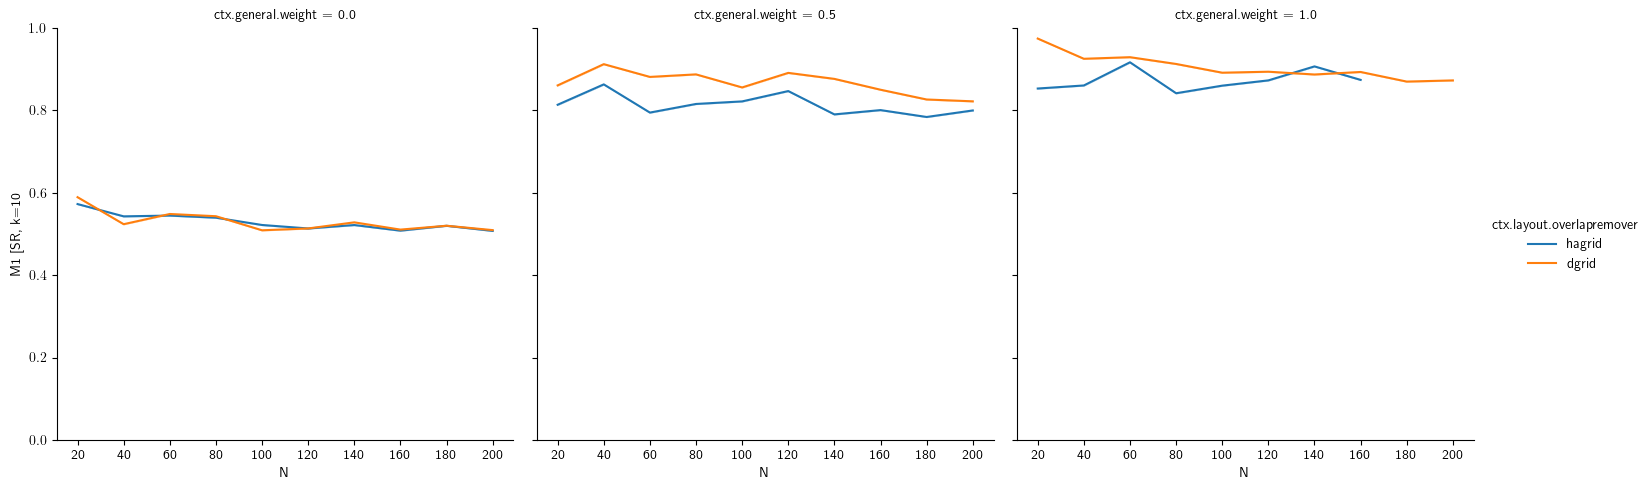

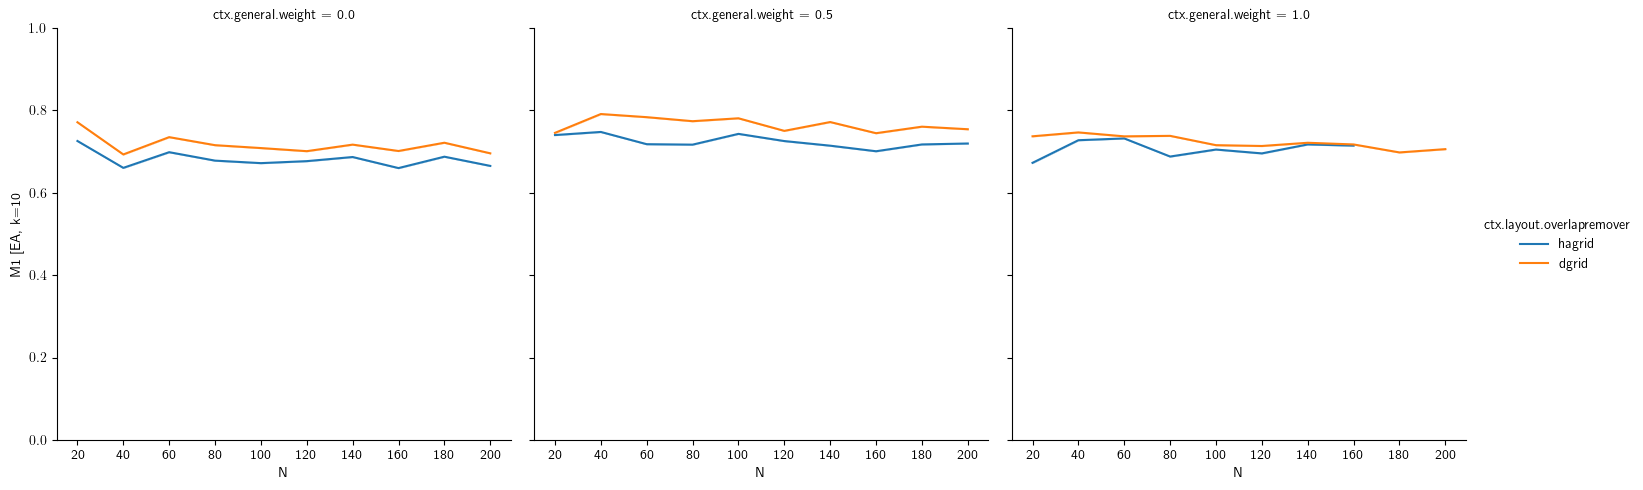

In [350]:
all_runs = df.sort_values('dataset')

p0 = sns.relplot(data=all_runs, kind='line', x='dataset', y='M1 [EA, k=10%]', hue='ctx.layout.overlapremover', col='ctx.general.weight')
p1 = sns.relplot(data=all_runs, kind='line', x='dataset', y='M1 [SR, k=10%]', hue='ctx.layout.overlapremover', col='ctx.general.weight')
p2 = sns.relplot(data=all_runs, kind='line', x='dataset', y='M1 [EA, k=10%] avg', hue='ctx.layout.overlapremover', col='ctx.general.weight')

p0.set(ylim=(0, 1))
p1.set(ylim=(0, 1))
p2.set(ylim=(0, 1))

for ax in list(p0.axes.flat) + list(p1.axes.flat) + list(p2.axes.flat):
    ax.set_xticklabels(labels=list(range(20,201,20)))
    ax.set_xlabel('N')

## Continuitiy

Same plot, but with continuity. Also here DGrid seems to be better.



/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/1186942050.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(range(20,201,20)))


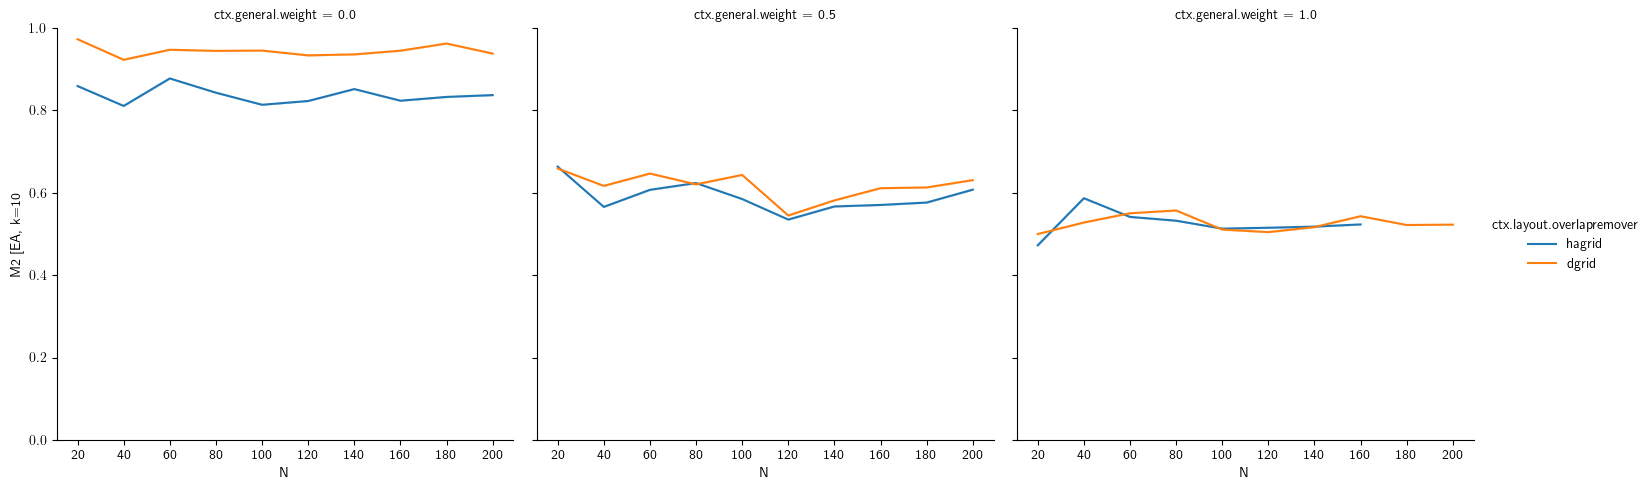

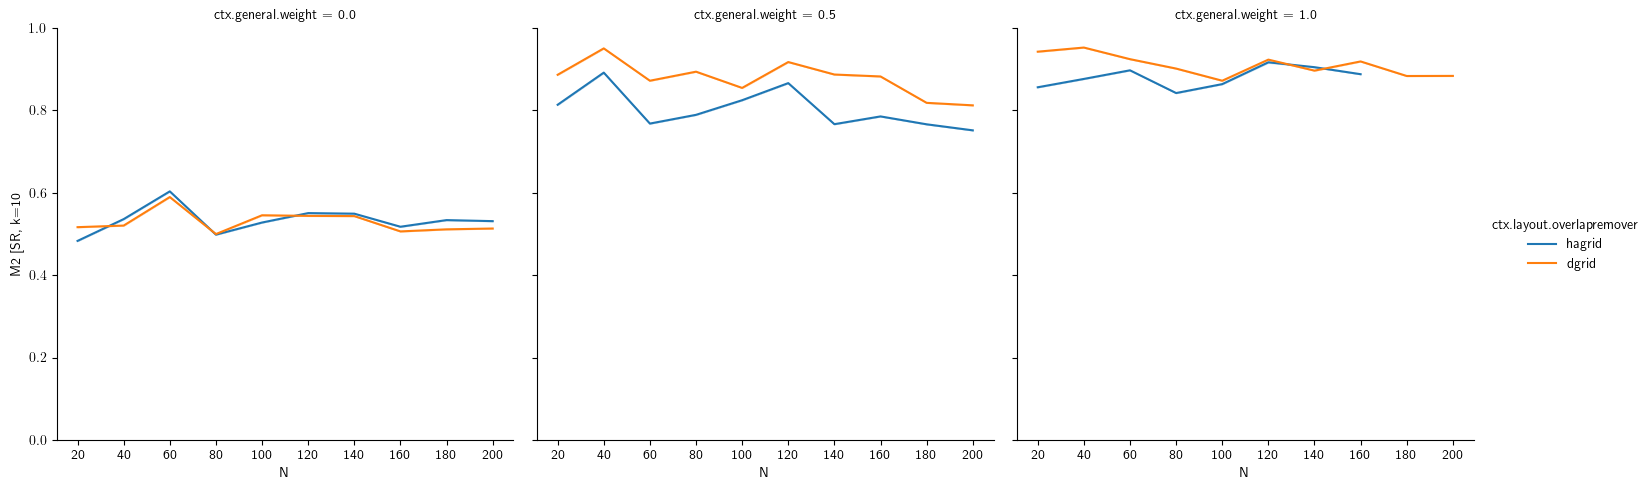

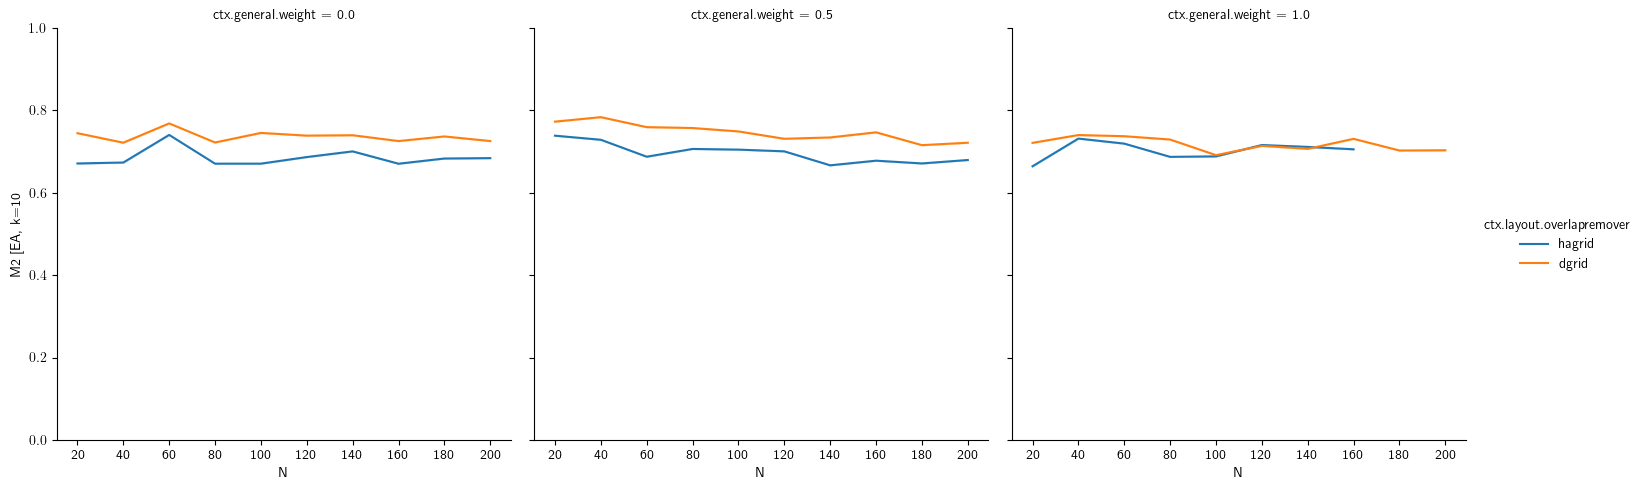

In [353]:
all_runs = df.sort_values('dataset')

p0 = sns.relplot(data=all_runs, kind='line', x='dataset', y='M2 [EA, k=10%]', hue='ctx.layout.overlapremover', col='ctx.general.weight')
p1 = sns.relplot(data=all_runs, kind='line', x='dataset', y='M2 [SR, k=10%]', hue='ctx.layout.overlapremover', col='ctx.general.weight')
p2 = sns.relplot(data=all_runs, kind='line', x='dataset', y='M2 [EA, k=10%] avg', hue='ctx.layout.overlapremover', col='ctx.general.weight')

p0.set(ylim=(0, 1))
p1.set(ylim=(0, 1))
p2.set(ylim=(0, 1))

for ax in list(p0.axes.flat) + list(p1.axes.flat) + list(p2.axes.flat):
    ax.set_xticklabels(labels=list(range(20,201,20)))
    ax.set_xlabel('N')

## Stress

Finally, stress. Here, lower is better. Also regarding this metric, DGrid performs better or comparably to Hagrid.

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_2591/2955613165.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=list(range(20,201,20)))


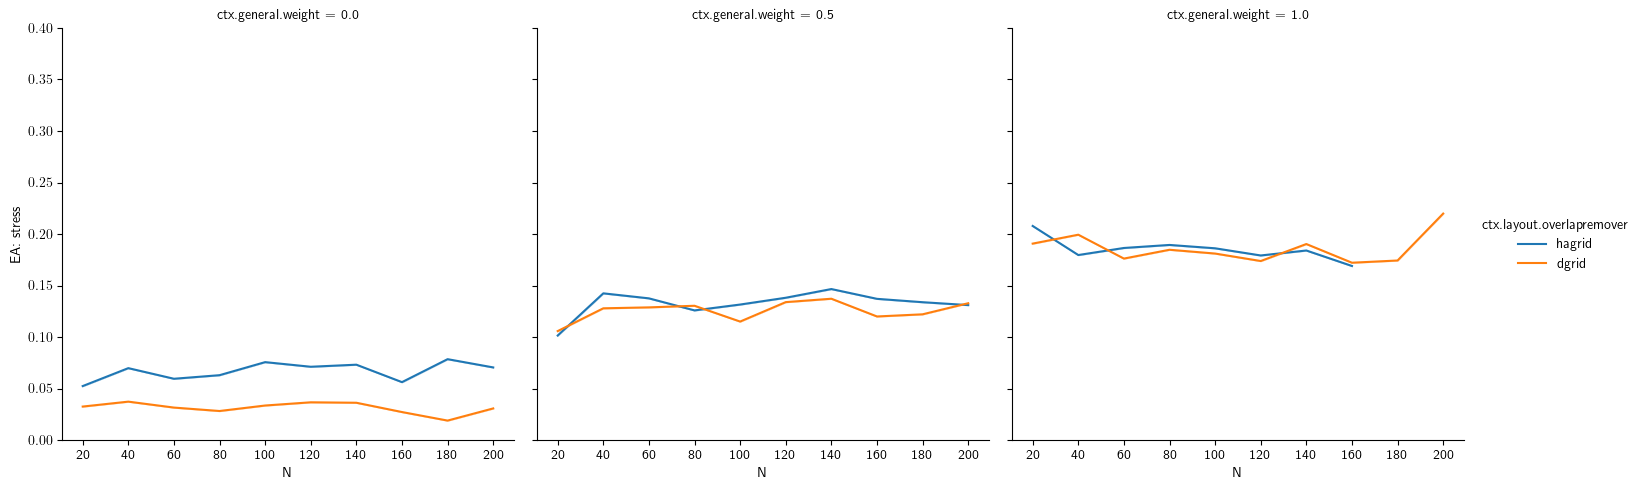

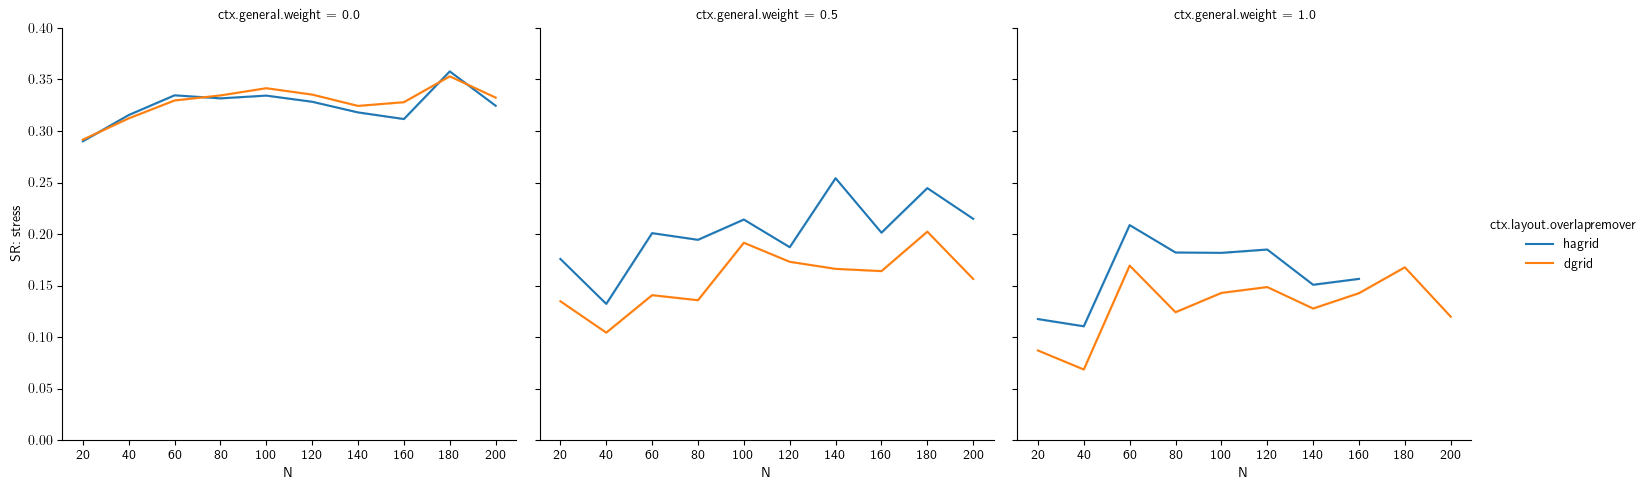

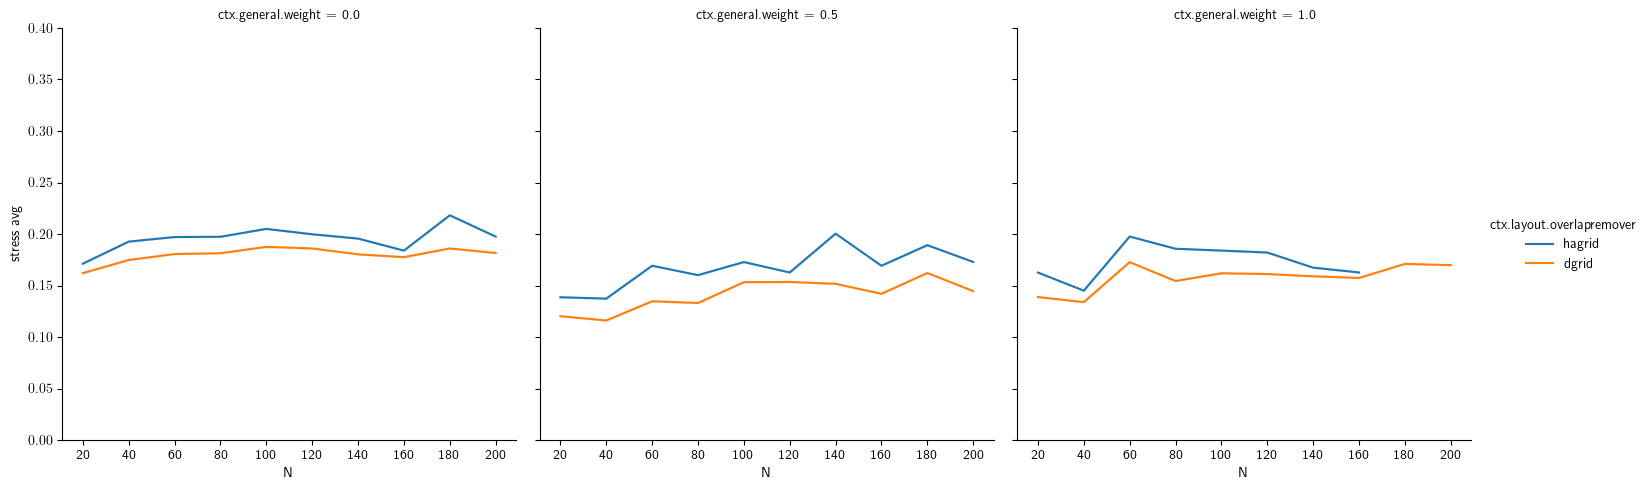

In [354]:
all_runs = df.sort_values('dataset')

p0 = sns.relplot(data=all_runs, kind='line', x='dataset', y='EA: stress', hue='ctx.layout.overlapremover', col='ctx.general.weight', )
p1 = sns.relplot(data=all_runs, kind='line', x='dataset', y='SR: stress', hue='ctx.layout.overlapremover', col='ctx.general.weight')
p2 = sns.relplot(data=all_runs, kind='line', x='dataset', y='stress avg', hue='ctx.layout.overlapremover', col='ctx.general.weight')

p0.set(ylim=(0, 0.4))
p1.set(ylim=(0, 0.4))
p2.set(ylim=(0, 0.4))


for ax in list(p0.axes.flat) + list(p1.axes.flat) + list(p2.axes.flat):
    ax.set_xticklabels(labels=list(range(20,201,20)))
    ax.set_xlabel('N')

# Conclusion

## Hagrid vs DGrid

DGrid performed better or comparable in both network and projection metrics. It is more flexible regarding grid size and does not have the same issues as the Hagrid ILP at weight 1. Thus we can recommend to _always_ use DGrid instead of (our implementation of) Hagrid for UnDRground Tubes (UT).

## Optimal vs. Heuristic Algorithms

This question relates mostly to the support computation. We found that an optimal support does lead to fewer edges in UT, but not necessarily fewer line crossings. If the instance at hand is small-ish, a tree support is fine, and the visualization does not need to be created in interactive time frames, then we think choosing the optimal support pays off. Otherwise we recommend resorting to heuristics.
